<a href="https://colab.research.google.com/github/MingSheng92/AE_denoise/blob/master/DL_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: keras-applications, google-pasta, tensorflow-estimator, astor, gast, wheel, absl-py, termcolor, wrapt, tensorboard, grpcio, numpy, opt-einsum, protobuf, six, keras-preprocessing
Required-by: stable-baselines, magenta, fancyimpute


In [2]:
!git clone https://github.com/MingSheng92/AE_denoise.git

Cloning into 'AE_denoise'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%load /content/AE_denoise/scripts/utility.py

from AE_denoise.scripts.utility import load_data, faceGrid, ResultGrid, subsample, AddNoiseToMatrix, noisy

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
img_data, label, img_size = load_data('/content/drive/My Drive/FaceDataset/CroppedYaleB', 0)
#img_data, label, img_size = load_data('/content/drive/My Drive/FaceDataset/ORL', 0)

In [7]:
img_size

(168, 168)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(img_data.T, label, test_size=0.1, random_state=111)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=111)

print("Total number of training samples: ", x_train.shape)
print("Total number of training samples: ", x_val.shape)
print("Total number of validation samples: ", x_test.shape)

Total number of training samples:  (1962, 28224)
Total number of training samples:  (218, 28224)
Total number of validation samples:  (243, 28224)


In [0]:
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

#x_train = x_train.reshape(-1, img_size[0], img_size[1], 1)
#x_val = x_val.reshape(-1, img_size[0], img_size[1], 1)
x_train = np.reshape(x_train, (len(x_train), img_size[0], img_size[1], 1))
x_val = np.reshape(x_val, (len(x_val), img_size[0], img_size[1], 1))
x_test = np.reshape(x_test, (len(x_test), img_size[0], img_size[1], 1)) 

In [0]:
# add noise to the face images
noise_factor = 0.35
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

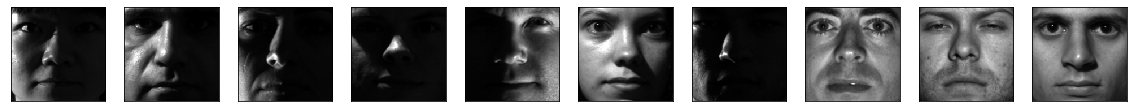

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train[i].reshape(img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

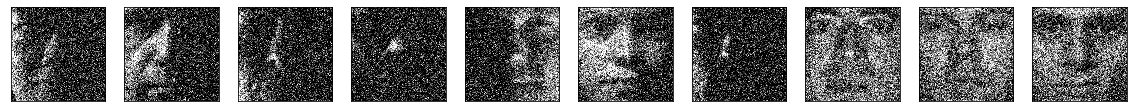

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train_noisy[i].reshape(img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [46]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Adadelta
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

def PSNRLoss(y_true, y_pred):
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    #tf.math.log
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

input_layer = Input(shape=(img_size[0], img_size[1], 1))

x = Conv2D(64, (5, 5), activation='relu', padding='same')(input_layer)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization(input_shape=(img_size[0], img_size[1], 1))(x)

x = Dropout(0.8, name='Dropout')(x)

x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (5, 5), activation='relu', padding='same')(x)
x = BatchNormalization(input_shape=(img_size[0], img_size[1], 1))(x)

output = Conv2D(1, (3, 3), padding='same')(x)

autoencoder = Model(input_layer, output)
adam = Adam(lr=1e-3)
#autoencoder.compile(optimizer=adam, loss='mse')
autoencoder.compile(optimizer=adam, loss='mse', metrics=[PSNRLoss])

In [47]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 168, 168, 1)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 168, 168, 64)      1664      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 168, 168, 32)      18464     
_________________________________________________________________
batch_normalization_15 (Batc (None, 168, 168, 32)      128       
_________________________________________________________________
Dropout (Dropout)            (None, 168, 168, 32)      0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 168, 168, 32)      9248      
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 168, 168, 64)      5126

In [48]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=15,
                batch_size=64,
                validation_data=(x_val_noisy, x_val))

Train on 1962 samples, validate on 218 samples
Epoch 1/15
1962/1962 [==============================] - 9s 5ms/step - loss: 0.3935 - PSNRLoss: 7.1834 - val_loss: 0.1785 - val_PSNRLoss: 7.4966
Epoch 2/15
1962/1962 [==============================] - 6s 3ms/step - loss: 0.0155 - PSNRLoss: 18.4213 - val_loss: 0.4297 - val_PSNRLoss: 3.6745
Epoch 3/15
1962/1962 [==============================] - 6s 3ms/step - loss: 0.0073 - PSNRLoss: 21.3764 - val_loss: 0.1021 - val_PSNRLoss: 9.9126
Epoch 4/15
1962/1962 [==============================] - 6s 3ms/step - loss: 0.0063 - PSNRLoss: 21.9960 - val_loss: 0.0483 - val_PSNRLoss: 13.1587
Epoch 5/15
1962/1962 [==============================] - 6s 3ms/step - loss: 0.0072 - PSNRLoss: 21.5946 - val_loss: 0.0115 - val_PSNRLoss: 19.3868
Epoch 6/15
1962/1962 [==============================] - 6s 3ms/step - loss: 0.0063 - PSNRLoss: 22.1124 - val_loss: 0.0129 - val_PSNRLoss: 18.9032
Epoch 7/15
1962/1962 [==============================] - 6s 3ms/step - loss: 0.004

In [0]:
denoise_prediction = autoencoder.predict(x_test_noisy)

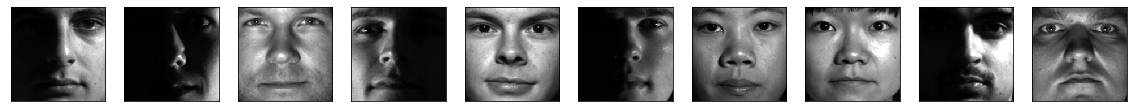

In [50]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

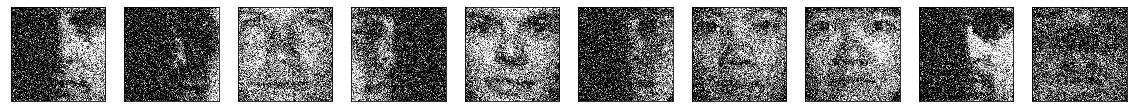

In [51]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

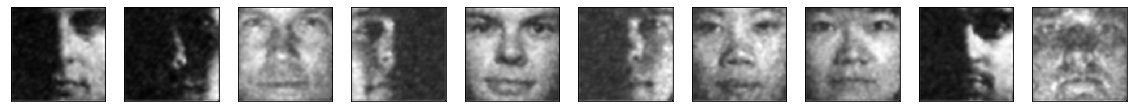

In [52]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(denoise_prediction[i].reshape(img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()